
Spam detection is one of the major applications of Machine Learning in the interwebs today. Pretty much all of the major email service providers have spam detection systems built in and automatically classify such mail as 'Junk Mail'. 

In this mission we will be using the Naive Bayes algorithm to create a model that can classify [dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) SMS messages as spam or not spam, based on the training we give to the model. It is important to have some level of intuition as to what a spammy text message might look like. Usually they have words like 'free', 'win', 'winner', 'cash', 'prize' and the like in them as these texts are designed to catch your eye and in some sense tempt you to open them. Also, spam messages tend to have words written in all capitals and also tend to use a lot of exclamation marks. To the recipient, it is usually pretty straightforward to identify a spam text and our objective here is to train a model to do that for us!

Being able to identify spam messages is a binary classification problem as messages are classified as either 'Spam' or 'Not Spam' and nothing else. Also, this is a supervised learning problem, as we will be feeding a labelled dataset into the model, that it can learn from, to make future predictions. 



### Introduction to the Naive Bayes Theorem ###

Bayes theorem is one of the earliest probabilistic inference algorithms developed by Reverend Bayes (which he used to try and infer the existence of God no less) and still performs extremely well for certain use cases. 

This is the 'Naive' bit of the theorem where it considers each feature to be independent of each other which may not always be the case and hence that can affect the final judgement.


### Step 1: Importing the dataset ### 


We will be using a [dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from the UCI Machine Learning repository which has a very good collection of datasets for experimental research purposes. The direct data link is [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/).




* The file name is SMSSpamCollection and it is saved in the folder, smsspamcollection. Because this is a tab separated dataset we will be using '\t' as the value for the 'sep' argument which specifies this format. 
* Also, rename the column names by specifying a list ['label, 'sms_message'] to the 'names' argument of read_table().


In [50]:
import pandas as pd
import numpy as np

df = pd.read_table("smsspamcollection/SMSSpamCollection" , sep='\t' ,header =None)

df = df.reindex(np.random.permutation(df.index))

df.reset_index(inplace=True, drop=True)

df.head()

,0,1
0,ham,"Helloooo... Wake up..! ""Sweet"" ""morning"" ""welc..."
1,ham,"Night has ended for another day, morning has c..."
2,ham,Armand says get your ass over to epsilon
3,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
4,ham,At home also.


In [51]:
df.columns=["label", "sms_message"]
df

,label,sms_message
0,ham,"Helloooo... Wake up..! ""Sweet"" ""morning"" ""welc..."
1,ham,"Night has ended for another day, morning has c..."
2,ham,Armand says get your ass over to epsilon
3,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
4,ham,At home also.
...,...,...
5567,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...
5568,ham,Pick you up bout 7.30ish? What time are and t...
5569,ham,Send to someone else :-)
5570,ham,I'm home. Doc gave me pain meds says everythin...


### Step 2: Data Preprocessing ###

Converting the labels to binary variables, 0 to represent 'ham'(i.e. not spam) and 1 to represent 'spam' for ease of computation. 

Scikit-learn only deals with numerical values and hence if we were to leave our label values as strings, scikit-learn would do the conversion internally(more specifically, the string labels will be cast to unknown float values). 
Hence, to avoid unexpected 'gotchas' later, it is good practice to have our categorical values be fed into our model as integers. 

In [52]:
df['label']=df['label'].replace('ham', 0)
df['label']=df['label'].replace('spam', 1)

In [53]:
df

,label,sms_message
0,0,"Helloooo... Wake up..! ""Sweet"" ""morning"" ""welc..."
1,0,"Night has ended for another day, morning has c..."
2,0,Armand says get your ass over to epsilon
3,0,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
4,0,At home also.
...,...,...
5567,0,Your opinion about me? 1. Over 2. Jada 3. Kusr...
5568,0,Pick you up bout 7.30ish? What time are and t...
5569,0,Send to someone else :-)
5570,0,I'm home. Doc gave me pain meds says everythin...


(-0.5, 799.5, 599.5, -0.5)

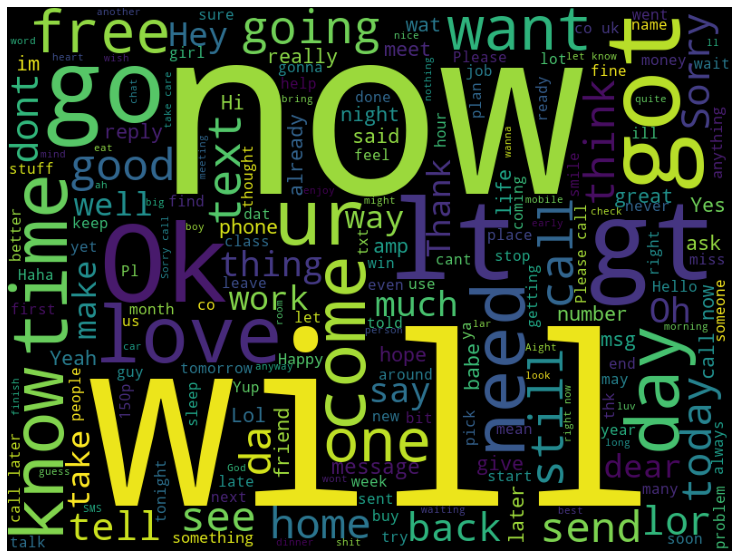

In [135]:
import matplotlib
import pylab as plt

from wordcloud import WordCloud
cloud=WordCloud(width=800, height=600).generate(" ".join(df['sms_message'])) 
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

### Bag of words ###

What we have here in our data set is a large collection of text data (5,572 rows of data). Most ML algorithms rely on numerical data to be fed into them as input, and email/sms messages are usually text heavy. 

Here we'd like to introduce the Bag of Words(BoW) concept which is a term used to specify the problems that have a 'bag of words' or a collection of text data that needs to be worked with. The basic idea of BoW is to take a piece of text and count the frequency of the words in that text. It is important to note that the BoW concept treats each word individually and the order in which the words occur does not matter. 

Using a process which we will go through now, we can convert a collection of documents to a matrix, with each document being a row and each word(token) being the column, and the corresponding (row,column) values being the frequency of occurrence of each word or token in that document.


Our objective here is to convert this set of text to a frequency distribution matrix, as follows:

Here as we can see, the documents are numbered in the rows, and each word is a column name, with the corresponding value being the frequency of that word in the document.

To handle this, we will be using sklearns 
[count vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) method which does the following:

* It tokenizes the string(separates the string into individual words) and gives an integer ID to each token.
* It counts the occurrence of each of those tokens.

** Please Note: ** 

* The CountVectorizer method automatically converts all tokenized words to their lower case form so that it does not treat words like 'He' and 'he' differently. It does this using the `lowercase` parameter which is by default set to `True`.

* It also ignores all punctuation so that words followed by a punctuation mark (for example: 'hello!') are not treated differently than the same words not prefixed or suffixed by a punctuation mark (for example: 'hello'). It does this using the `token_pattern` parameter which has a default regular expression which selects tokens of 2 or more alphanumeric characters.

* The third parameter to take note of is the `stop_words` parameter. Stop words refer to the most commonly used words in a language. They include words like 'am', 'an', 'and', 'the' etc. By setting this parameter value to `english`, CountVectorizer will automatically ignore all words(from our input text) that are found in the built in list of english stop words in scikit-learn. This is extremely helpful as stop words can skew our calculations when we are trying to find certain key words that are indicative of spam.

We will dive into the application of each of these into our model in a later step, but for now it is important to be aware of such preprocessing techniques available to us when dealing with textual data.

### Implementing Bag of Words in scikit-learn ###

Now that we have implemented the BoW concept from scratch, let's go ahead and use scikit-learn to do this process.

In [54]:
'''
Here we will look to create a frequency matrix on a smaller document set to make sure we understand how the 
document-term matrix generation happens. We have created a sample document set 'documents'.
'''
documents = ['Hello, how are you!',
                'Win money, win from home.',
                'Call me now.',
                'Hello, Call hello you tomorrow?']


STEP 1 - Import the sklearn.feature_extraction.text.CountVectorizer method and create an instance of it called 'count_vector'. 

** Data preprocessing with CountVectorizer() **

In Step 2.2, we implemented a version of the CountVectorizer() method from scratch that entailed cleaning our data first. This cleaning involved converting all of our data to lower case and removing all punctuation marks. CountVectorizer() has certain parameters which take care of these steps for us. They are:

* `lowercase = True`
    
    The `lowercase` parameter has a default value of `True` which converts all of our text to its lower case form.


* `token_pattern = (?u)\\b\\w\\w+\\b`
    
    The `token_pattern` parameter has a default regular expression value of `(?u)\\b\\w\\w+\\b` which ignores all punctuation marks and treats them as delimiters, while accepting alphanumeric strings of length greater than or equal to 2, as individual tokens or words.


* `stop_words`

    The `stop_words` parameter, if set to `english` will remove all words from our document set that match a list of English stop words which is defined in scikit-learn. Considering the size of our dataset and the fact that we are dealing with SMS messages and not larger text sources like e-mail, we will not be setting this parameter value.

The use `stop_words` parameter and set its value to `english`. This will automatically ignore all words(from our input text) that are found in a built in list of English stop words in scikit-learn.

You can take a look at all the parameter values of your `count_vector` object by simply printing out the object as follows:

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(ngram_range=(1, 1), lowercase = True , stop_words =  'english')

STEP 2 - Fit your document dataset to the CountVectorizer object you have created using fit(), and get the list of words which have been categorized as features using the get_feature_names() method.

In [56]:
count_vector.fit_transform(documents)
word_count = count_vector.get_feature_names()
word_count

['hello', 'home', 'money', 'tomorrow', 'win']

The `get_feature_names()` method returns our feature names for this dataset, which is the set of words that make up our vocabulary for 'documents'.

STEP 3 - 
Create a matrix with the rows being each of the document, and the columns being each word. 
The corresponding (row, column) value is the frequency of occurrence of that word(in the column) in a particular
document(in the row). You can do this using the transform() method and passing in the document data set as the 
argument. The transform() method returns a matrix of numpy integers, you can convert this to an array using
toarray(). Call the array 'doc_array'


In [57]:
doc_array =  count_vector.fit_transform(documents).toarray()
doc_array

array([[1, 0, 0, 0, 0],
       [0, 1, 1, 0, 2],
       [0, 0, 0, 0, 0],
       [2, 0, 0, 1, 0]])

Now we have a clean representation of the documents in terms of the frequency distribution of the words in them. To make it easier to understand our next step is to convert this array into a dataframe and name the columns appropriately.

 STEP 4 -
 Convert the array we obtained, loaded into 'doc_array', into a dataframe and set the column names to 
the word names(which you computed earlier using get_feature_names(). Call the dataframe 'frequency_matrix'.


In [58]:
frequency_matrix = pd.DataFrame((doc_array),columns = word_count)
frequency_matrix

,hello,home,money,tomorrow,win
0,1,0,0,0,0
1,0,1,1,0,2
2,0,0,0,0,0
3,2,0,0,1,0


Here is the successfully implemented a Bag of Words problem for a document dataset that we created. 


### Step 3: Training and testing sets ###

Now that we have understood how to deal with the Bag of Words problem we can get back to our dataset and proceed with our analysis. Our first step in this regard would be to split our dataset into a training and testing set so we can test our model later. 

In [88]:
X_train_sms, X_test_sms, y_train, y_test = train_test_split(df['sms_message'], 
                                                    df['label'], 
                                                    random_state=42)
# the split ratio is 25% by default
# Here df['sms_message'] is X and df['label'] is y for both test and training data
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


In [89]:
df.shape

(5572, 2)

In [92]:
X_train_sms

4281    Yar... I tot u knew dis would happen long ago ...
585                I want to be inside you every night...
4545    ALRITE SAM ITS NIC JUST CHECKIN THAT THIS IS U...
3034    Nothing just getting msgs by dis name wit diff...
2758                      Is there any training tomorrow?
                              ...                        
3772    I am real, baby! I want to bring out your inne...
5191                        I am late. I will be there at
5226    Hmm...my uncle just informed me that he's payi...
5390    Can you plz tell me the ans. BSLVYL sent via f...
860                Po de :-):):-):-):-). No need job aha.
Name: sms_message, Length: 4179, dtype: object

Here X_train_sms has teh first column as index and the second column as SMS message.

In [78]:
y_train

710     0
3740    1
2711    0
3155    0
3748    1
       ..
905     0
5192    0
3980    0
235     0
5157    0
Name: label, Length: 4179, dtype: int64

In [ ]:
Here X_train_sms has the first column as index and the second column as label (0 and 1).

Split the dataset into a training and testing set by using the train_test_split method in sklearn. Split the data
using the following variables:
* `X_train_sms` is our training data for the 'sms_message' column.
* `y_train` is our training data for the 'label' column
* `X_test_sms` is our testing data for the 'sms_message' column.
* `y_test` is our testing data for the 'label' column
Print out the number of rows we have in each our training and testing data.


### Step 4: Applying Bag of Words processing to our dataset. ###

Now that we have split the data, our next objective is to follow the steps from Step 2: Bag of words and convert our data into the desired matrix format. To do this we will be using CountVectorizer() as we did before. There are two  steps to consider here:

* Firstly, we have to fit our training data (`X_train`) into `CountVectorizer()` and return the matrix.
* Secondly, we have to transform our testing data (`X_test`) to return the matrix. 

Note that `X_train` is our training data for the 'sms_message' column in our dataset and we will be using this to train our model. 

`X_test` is our testing data for the 'sms_message' column and this is the data we will be using(after transformation to a matrix) to make predictions on. We will then compare those predictions with `y_test` in a later step. 

For now, we have provided the code that does the matrix transformations for you!

The code for this segment is in 2 parts. Firstly, we are learning a vocabulary dictionary for the training data 
and then transforming the data into a document-term matrix; secondly, for the testing data we are only 
transforming the data into a document-term matrix.

We will provide the transformed data to students in the variables 'training_data' and 'testing_data'.

Refer to the following link for further details:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [64]:
from sklearn.feature_extraction.text import CountVectorizer


In [90]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(ngram_range=(1, 1), lowercase = True , stop_words =  'english')

# Fit the training data and then return the matrix
X_train = count_vector.fit_transform(X_train_sms) 
# to get the the list of feature words that are lowercase with no puttutaion or stop words
#Since you fit transform X data training
# they convert data to integer data

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
X_test = count_vector.transform(X_test_sms)
#Since you transform X data testing
# they convert data to integer data

In [91]:
X_train[0:5]

<5x7293 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [93]:
X_test[0:5]

<5x7293 sparse matrix of type '<class 'numpy.int64'>'
	with 52 stored elements in Compressed Sparse Row format>

SMSmessage has been coverted to integer data.

Here is the training data feature list.

In [98]:
X_train_feature_list = count_vector.get_feature_names()
X_train_feature_list

['00',
 '000',
 '000pes',
 '008704050406',
 '0089',
 '0121',
 '01223585236',
 '01223585334',
 '0125698789',
 '02',
 '0207',
 '02072069400',
 '02073162414',
 '021',
 '03',
 '04',
 '0430',
 '05',
 '050703',
 '0578',
 '06',
 '07',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '0721072',
 '07732584351',
 '07734396839',
 '07742676969',
 '0776xxxxxxx',
 '07781482378',
 '07786200117',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '08000407165',
 '08000776320',
 '08000839402',
 '08000930705',
 '08000938767',
 '08001950382',
 '08002888812',
 '08002986030',
 '08002986906',
 '08006344447',
 '0808',
 '08081263000',
 '08081560665',
 '0825',
 '083',
 '0844',
 '08448350055',
 '08448714184',
 '0845',
 '08450542832',
 '08452810071',
 '08452810073',
 '08452810075over18',
 '0870',
 '08700469649',
 '08700621170150p',
 '08

In [99]:
doc_array =  X_train.toarray()
doc_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [101]:
frequency_matrix_X_train = pd.DataFrame((doc_array),columns = X_train_feature_list)
frequency_matrix_X_train

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,ú1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
See the rows have been reducted since stopwords used in english have been removed.

### Step 5: Naive Bayes implementation using scikit-learn ###

 We will be using sklearns `sklearn.naive_bayes` method to make predictions on our dataset. 

Specifically, we will be using the multinomial Naive Bayes implementation. This particular classifier is suitable for classification with discrete features (such as in our case, word counts for text classification). It takes in integer word counts as its input. On the other hand Gaussian Naive Bayes is better suited for continuous data as it assumes that the input data has a Gaussian(normal) distribution.

In [ ]:
'''
Instructions:

We have loaded the training data into the variable 'training_data' and the testing data into the 
variable 'testing_data'.

Import the MultinomialNB classifier and fit the training data into the classifier using fit(). Name your classifier
'naive_bayes'. You will be training the classifier using 'training_data' and y_train' from our split earlier. 
'''

In [108]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train , y_train)
# not X_train since it a 2 column , training data is one column

MultinomialNB()

In [ ]:
'''
Instructions:
Now that our algorithm has been trained using the training data set we can now make some predictions on the test data
stored in 'testing_data' using predict(). Save your predictions into the 'predictions' variable.
'''

In [104]:
predictions = naive_bayes.predict(X_test)
predictions

array([1, 1, 0, ..., 0, 0, 0])

Now that predictions have been made on our test set, we need to check the accuracy of our predictions.

### Step 6: Evaluating our model ###


We will be using all 4 metrics to make sure our model does well. For all 4 metrics whose values can range from 0 to 1, having a score as close to 1 as possible is a good indicator of how well our model is doing.

'''
Instructions:
Compute the accuracy, precision, recall and F1 scores of your model using your test data 'y_test' and the predictions
you made earlier stored in the 'predictions' variable.
'''

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(predictions,y_test)))
print('Precision score: ', format(precision_score(predictions,y_test)))
print('Recall score: ', format(recall_score(predictions,y_test)))
print('F1 score: ', format(f1_score(predictions,y_test)))

Accuracy score:  0.9813352476669059
Precision score:  0.9226804123711341
Recall score:  0.9421052631578948
F1 score:  0.9322916666666667


In [ ]:
This classifier has great accuracy as well as recall.

In [ ]:
### Step 7: Logtistic Regression implementation using scikit-learn ###

In [109]:
from sklearn.linear_model import LogisticRegression
logitic_regression = LogisticRegression(random_state=42)
logitic_regression.fit(X_train , y_train)
# not X_train since it a 2 column , training data is one column

LogisticRegression(random_state=42)

In [111]:
predictions_logistic_regression = logitic_regression.predict(X_test)
predictions_logistic_regression

array([1, 1, 0, ..., 0, 0, 0])

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(predictions_logistic_regression,y_test)))
print('Precision score: ', format(precision_score(predictions_logistic_regression,y_test)))
print('Recall score: ', format(recall_score(predictions_logistic_regression,y_test)))
print('F1 score: ', format(f1_score(predictions_logistic_regression,y_test)))

Accuracy score:  0.9798994974874372
Precision score:  0.8711340206185567
Recall score:  0.9825581395348837
F1 score:  0.9234972677595628


In [ ]:
This classifier has results in lower accuracy and precision but it performs great in recall.

In [ ]:
### Step 8: Logtistic Regression implementation using scikit-learn and Randomised Search CV and cv = 5###

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from numpy import random
np.random.seed(42) 

model = LogisticRegression(random_state = 42)
import warnings
warnings.filterwarnings('ignore')

param_grid = [{
'max_iter': randint(low=1, high=1000), 'penalty' :['l2', 'l1', 'elasticnet','none'],
    'C': randint(low=0.1, high=100)
                  }]
gs = RandomizedSearchCV(model,param_grid,cv=5, n_iter=1000, scoring="accuracy",random_state = 42)
gs.fit(X_train, y_train)
gs.best_params_

{'C': 65, 'max_iter': 10, 'penalty': 'none'}

In [117]:
cvreslt=gs.cv_results_

cvreslt_params=[str(i) for i in cvreslt["params"]]

for accuracy, params in sorted(zip(cvreslt["mean_test_score"], cvreslt_params)):
    print(np.mean(accuracy), params)

nan {'C': 51, 'max_iter': 861, 'penalty': 'elasticnet'}
0.9798971435120191 {'C': 71, 'max_iter': 701, 'penalty': 'l2'}
nan {'C': 82, 'max_iter': 215, 'penalty': 'elasticnet'}
0.9789396326963299 {'C': 2, 'max_iter': 662, 'penalty': 'l2'}
0.9798971435120191 {'C': 63, 'max_iter': 956, 'penalty': 'l2'}
0.9798971435120191 {'C': 74, 'max_iter': 88, 'penalty': 'l2'}
0.9808543678193852 {'C': 1, 'max_iter': 344, 'penalty': 'none'}
0.9808543678193852 {'C': 51, 'max_iter': 96, 'penalty': 'none'}
0.9808543678193852 {'C': 99, 'max_iter': 872, 'penalty': 'none'}
nan {'C': 29, 'max_iter': 806, 'penalty': 'l1'}
nan {'C': 32, 'max_iter': 460, 'penalty': 'l1'}
0.9801363779617798 {'C': 8, 'max_iter': 346, 'penalty': 'l2'}
0.9808543678193852 {'C': 1, 'max_iter': 340, 'penalty': 'none'}
0.9808543678193852 {'C': 21, 'max_iter': 253, 'penalty': 'none'}
nan {'C': 88, 'max_iter': 561, 'penalty': 'elasticnet'}
nan {'C': 58, 'max_iter': 511, 'penalty': 'l1'}
0.9808543678193852 {'C': 91, 'max_iter': 700, 'penalty

In [128]:
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(C=90, max_iter=529, penalty='none', random_state= 42)
clf.fit(X_train,y_train)



LogisticRegression(C=90, max_iter=529, penalty='none', random_state=42)

In [129]:
predictions_logistic_regression = clf.predict(X_test)
predictions_logistic_regression

array([1, 1, 0, ..., 0, 0, 0])

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(predictions_logistic_regression,y_test)))
print('Precision score: ', format(precision_score(predictions_logistic_regression,y_test)))
print('Recall score: ', format(recall_score(predictions_logistic_regression,y_test)))
print('F1 score: ', format(f1_score(predictions_logistic_regression,y_test)))

Accuracy score:  0.9813352476669059
Precision score:  0.8969072164948454
Recall score:  0.9666666666666667
F1 score:  0.93048128342246


In [ ]:
This classifier has results in higher accuracy, f1_score,accuracy and precision but it performs poor in recall.

That means the predictions given in the original email are 98% accurate.

In [ ]:
**PICKING MY OWN SPAM EMAIL AND CHECKING IF THE CAN PREDICT **

In [144]:
email = ["Hello aditikochhar,Test your luck, Onezy gives you One Free Spin on the Bonus Wheel!Every spin will give you a great bonus!Spin the wheel!Do not miss this amazing opportunity,you only get One Shot to win a maximum of the $10 Welcome bonus and a 100% Deposit bonus. Terms and conditions apply.Play now!" ]

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(ngram_range=(1, 1), lowercase = True , stop_words =  'english')

In [146]:
count_vector.fit_transform(email)
word_count_email = count_vector.get_feature_names()
word_count_email

['10',
 '100',
 'aditikochhar',
 'amazing',
 'apply',
 'bonus',
 'conditions',
 'deposit',
 'free',
 'gives',
 'great',
 'hello',
 'luck',
 'maximum',
 'miss',
 'onezy',
 'opportunity',
 'play',
 'shot',
 'spin',
 'terms',
 'test',
 'welcome',
 'wheel',
 'win']

In [147]:
email_array =  count_vector.fit_transform(email).toarray()
email_array

array([[1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        1, 2, 1]])

In [148]:
frequency_matrix = pd.DataFrame((email_array),columns = word_count_email)
frequency_matrix

,10,100,aditikochhar,amazing,apply,bonus,conditions,deposit,free,gives,...,onezy,opportunity,play,shot,spin,terms,test,welcome,wheel,win
0,1,1,1,1,1,4,1,1,1,1,...,1,1,1,1,3,1,1,1,2,1


In [151]:
email_label=np.array([[1]])

In [152]:
email_label

array([[1]])

In [ ]:
I labelled it as spam since it is spam.

In [155]:
email_dataframe = pd.DataFrame((email_label))
email_dataframe

,0
0,1


In [156]:
email_dataframe.rename({0: 'email_label'}, axis=1)

,email_label
0,1


In [158]:
concatenated_email=np.concatenate((email_dataframe, frequency_matrix), axis=1)
concatenated_email

array([[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
        1, 1, 2, 1]])

In [160]:
email_dataframe_con = pd.DataFrame(concatenated_email)
email_dataframe_con 

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,1,1,1,1,4,1,1,1,...,1,1,1,1,3,1,1,1,2,1


In [162]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_2 = MultinomialNB()
naive_bayes_2.fit(frequency_matrix , email_dataframe)

MultinomialNB()

One more email as testing email. It is above email with a few variations.

In [270]:
email_2 = ["Hello there spinters,Test your dick, Onezy gives you One Free Spin on the Bonus Wheel!Every spin will give you a great bonus!Spin the wheel!Do not miss this amazing opportunity,you only get One Shot to win a maximum of the $100 Welcome bonus and a 1000% Deposit bonus. Terms and rules apply.Play now!"]

In [271]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(ngram_range=(1, 1), lowercase = True , stop_words =  'english')

In [272]:
count_vector.fit_transform(email_2)
word_count_email_2 = count_vector.get_feature_names()
word_count_email_2

['100',
 '1000',
 'amazing',
 'apply',
 'bonus',
 'deposit',
 'dick',
 'free',
 'gives',
 'great',
 'hello',
 'maximum',
 'miss',
 'onezy',
 'opportunity',
 'play',
 'rules',
 'shot',
 'spin',
 'spinters',
 'terms',
 'test',
 'welcome',
 'wheel',
 'win']

In [273]:
email_array_2 =  count_vector.fit_transform(email_2).toarray()
email_array_2

array([[1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
        1, 2, 1]])

In [274]:
frequency_matrix_2 = pd.DataFrame((email_array_2),columns = word_count_email_2)
frequency_matrix_2

,100,1000,amazing,apply,bonus,deposit,dick,free,gives,great,...,play,rules,shot,spin,spinters,terms,test,welcome,wheel,win
0,1,1,1,1,4,1,1,1,1,1,...,1,1,1,3,1,1,1,1,2,1


In [275]:
email_label_2=np.array([[1]])

In [276]:
email_dataframe_2 = pd.DataFrame((email_label_2))
email_dataframe_2

,0
0,1


In [277]:
email_dataframe_2.rename({0: 'email_label'}, axis=1)

,email_label
0,1


In [278]:
prediction_email_2 = naive_bayes_2.predict(frequency_matrix_2)
prediction_email_2

array([1])

In [279]:
from sklearn.metrics import accuracy_score
print('Accuracy score: ', format(accuracy_score(prediction_email_2,email_label_2)))

Accuracy score:  1.0


That makes sense since it just the above email that has been changed a little.

In [ ]:
**ngrams_range(2,2)**

In [181]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(ngram_range=(2, 2), lowercase = True , stop_words =  'english')

# Fit the training data and then return the matrix
X_train = count_vector.fit_transform(X_train_sms) 
# to get the the list of feature words that are lowercase with no puttutaion or stop words
#Since you fit transform X data training
# they convert data to integer data

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
X_test = count_vector.transform(X_test_sms)
#Since you transform X data testing
# they convert data to integer data

In [182]:
X_train_feature_list = count_vector.get_feature_names()
X_train_feature_list

['00 easter',
 '00 sub',
 '00 subs',
 '000 bonus',
 '000 cash',
 '000 homeowners',
 '000 pounds',
 '000 price',
 '000 prize',
 '000 xmas',
 '000pes 48',
 '008704050406 sp',
 '0089 digits',
 '0121 2025050',
 '01223585236 xx',
 '01223585334 cum',
 '0125698789 ring',
 '02 06',
 '02 09',
 '0207 083',
 '0207 153',
 '02072069400 bx',
 '02073162414 costs',
 '021 3680',
 '03 05',
 '03 2nd',
 '03 final',
 '03 marsms',
 '0430 jul',
 '05 05',
 '05 prize',
 '050703 csbcm4235wc1n3xx',
 '06 03',
 '06 05',
 '06 11',
 '06 good',
 '07 11',
 '07046744435 arrange',
 '07090298926 schedule',
 '07099833605 schedule',
 '07123456789 87077',
 '07732584351 rodger',
 '07734396839 ibh',
 '07742676969 shows',
 '0776xxxxxxx ve',
 '07781482378 com',
 '07801543489 guaranteed',
 '07808 xxxxxx',
 '07808247860 shows',
 '07808726822 awarded',
 '078498 shows',
 '0789xxxxxxx today',
 '07946746291 07880867867',
 '07973788240 shows',
 '07xxxxxxxxx shows',
 '07xxxxxxxxx won',
 '08 03',
 '0800 0721072',
 '0800 169',
 '0800 195

In [183]:
doc_array =  X_train.toarray()
doc_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [184]:
frequency_matrix_X_train = pd.DataFrame((doc_array),columns = X_train_feature_list)
frequency_matrix_X_train

,00 easter,00 sub,00 subs,000 bonus,000 cash,000 homeowners,000 pounds,000 price,000 prize,000 xmas,...,zeros savings,zhong se,zindgi wo,zoe 18,zoe just,zogtorius ve,zoom cine,zouk nichols,zyada kisi,ú1 20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train , y_train)
# not X_train since it a 2 column , training data is one column

MultinomialNB()

In [186]:
predictions = naive_bayes.predict(X_test)
predictions

array([1, 1, 0, ..., 0, 0, 0])

In [187]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(predictions,y_test)))
print('Precision score: ', format(precision_score(predictions,y_test)))
print('Recall score: ', format(recall_score(predictions,y_test)))
print('F1 score: ', format(f1_score(predictions,y_test)))

Accuracy score:  0.9798994974874372
Precision score:  0.8556701030927835
Recall score:  1.0
F1 score:  0.9222222222222222


In [ ]:
It leads to lower accuracy and higher recall.

CONCLUSIONS:
    - Naive bayers predicts with high accuracy of over 98%.

### Step 7: Conclusion ###

    - Naive bayers predicts with high accuracy of over 98%.
    - For spam email prediction, the accuracy is close to 100%.
    
One of the major advantages that Naive Bayes has over other classification algorithms is its ability to handle an extremely large number of features. In our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them. The other major advantage it has is its relative simplicity. Naive Bayes' works well right out of the box and tuning it's parameters is rarely ever necessary, except usually in cases where the distribution of the data is known. 
It rarely ever overfits the data. Another important advantage is that its model training and prediction times are very fast for the amount of data it can handle. All in all, Naive Bayes' really is a gem of an algorithm!

